In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Imports

## DataSet

In [2]:
data = pd.read_csv('Data_Filtree_Etape1.csv')

## Fonctions

In [3]:
import mes_fonctions as stt

## Transformation des transactions en Clients

In [4]:
clients = stt.defined_new_features_V2(data=data)

In [5]:
# Filtrage de données 
clients_bis = clients[
    (clients.Mean_Invoice_Price<3000) &
    (clients.Freq_Invoice<60) &
    (clients.Somme_Invoice<25000) &
    (clients.Somme_Invoice<40000) &
    (clients.Mean_Invoice_Price_Canceled>-250) &
    (clients.Nb_Article_Total<12500)
    ]

## Application des modélisation de Cluster

In [6]:
#import mes_fonctions as stt
# SEPARATIONS EN 10 CLUSTERS
## Le DataSet clients
clients = clients.copy()
clients = stt.ajoute_quantiles(data_train=clients, data_to_apply=clients)
clients = stt.modelisation_cluster_rfm(clients)

## Le DataSet clients filtré
clients_bis = clients_bis.copy()
clients_bis = stt.ajoute_quantiles(data_train=clients_bis, data_to_apply=clients_bis)
clients_bis = stt.modelisation_cluster_rfm(clients_bis)

In [7]:
##### UTILISATION DE 9 CLUSTERS
#import mes_fonctions as stt
## Le DataSet clients
#clients = clients.copy()
#clients = stt.ajoute_quantiles(data_train=clients, data_to_apply=clients)
#clients = stt.modelisation_cluster_rfm_V2(clients)

## Le DataSet clients filtré
#clients_bis = clients_bis.copy()
#clients_bis = stt.ajoute_quantiles(data_train=clients_bis, data_to_apply=clients_bis)
#clients_bis = stt.modelisation_cluster_rfm_V2(clients_bis)

### Liste des Features

In [8]:
## Les listes de features
l1 = ['Recency', 'Freq_Invoice', 'Somme_Invoice', 'Mean_Invoice_Price',
       'Mean_Article_Price', 'Nb_Article_Total', 'Mean_Invoice_Price_Canceled',
       'FI_Price', 'FI_Article_Nb', 'FI_Mean_Article_Price']
l2 = ['Recency', 'Freq_Invoice', 'Somme_Invoice', 'Mean_Invoice_Price',
       'Mean_Article_Price', 'Nb_Article_Total', 'Mean_Invoice_Price_Canceled',
       ]
l3 = ['Recency', 'Freq_Invoice', 'Somme_Invoice', 'Mean_Invoice_Price',]
l4 = ['Recency', 'Freq_Invoice', 'Mean_Invoice_Price',]

### Visualisation PCA

Debut  2018-10-11 18:34:47.545870
Les 2 composantes de PCA représententsur la variance totale : [ 0.4579957   0.71662752]
Fin  2018-10-11 18:34:47.752714  -->  0:00:00.206844


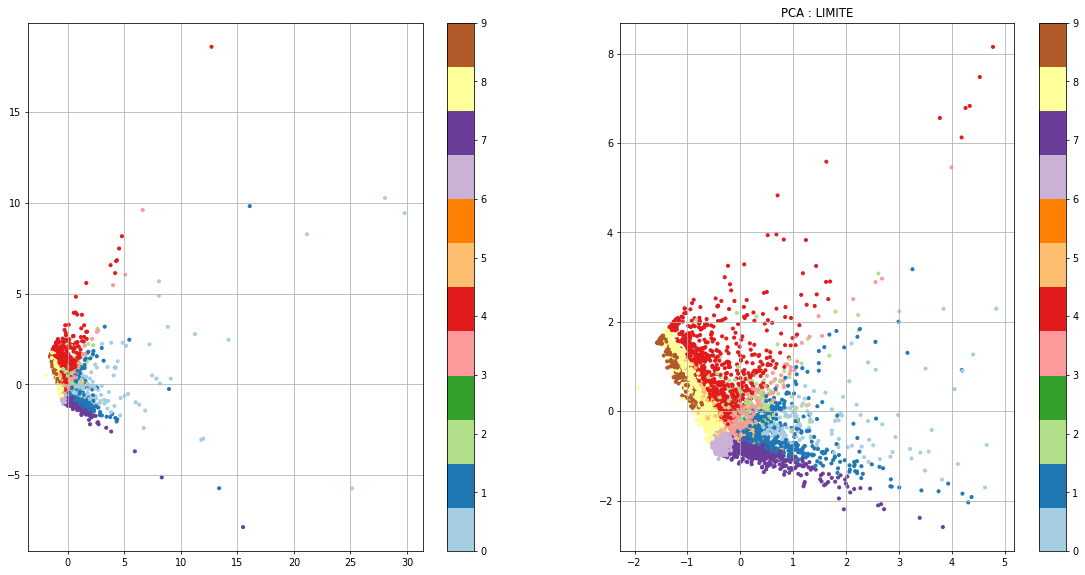

In [9]:
stt.visualise_PCA(l_col=l3, col_couleur='couleur', data=clients, x_limit=5)

Debut  2018-10-11 18:34:48.223603
Les 2 composantes de PCA représententsur la variance totale : [ 0.4312054   0.75391193]
Fin  2018-10-11 18:34:48.226776  -->  0:00:00.003173


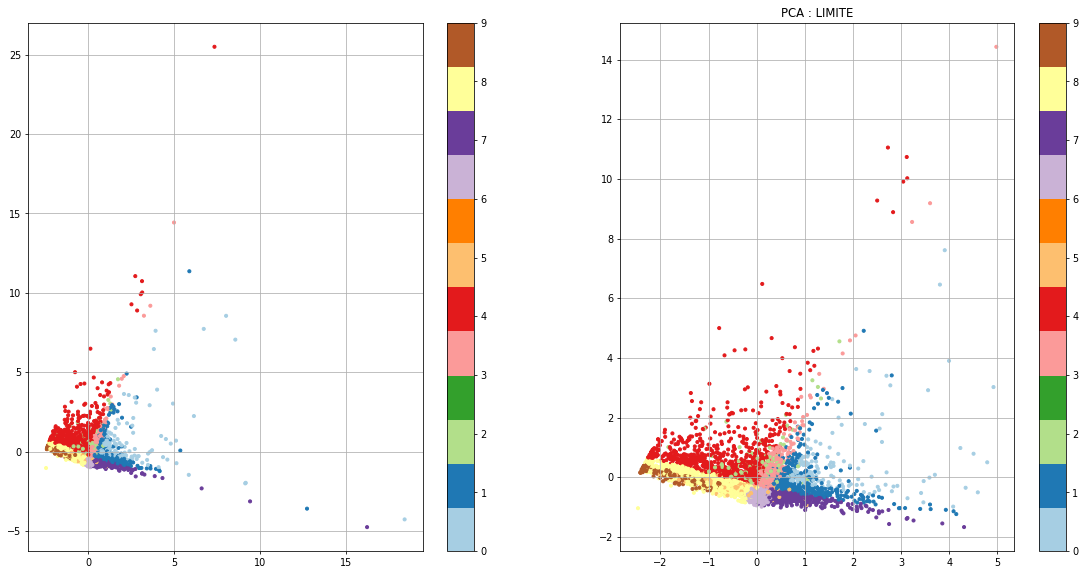

In [10]:
stt.visualise_PCA(l_col=l4, col_couleur='couleur', data=clients, x_limit=5)

# Modélisation du Problème

Rappel : 
--------
- L'objectif est de faire la classification des données dans les clusters définis (par le modéle de cluster défini) DES le achat : c'est à dire sans avoir un historique pour ces nouveaux clients 
- Pour cela nous devons modéliser la classification à partir de features qui sont à notre disposition dès le 1e achat

Nous allons donc modéliser la classification à partir des features adéquat en faisant attention à ce que ces dernières soient disponibles dès le 1e achat.

## Présentation de nos tests 
> Nous allons tester 6 classifiers différents pour modéliser notre problématique
- K_NN
- SVM Classifier avec un kernel trick 'RBF' (pour "Radial Basis Function kernel")
- SVM Classifier avec kernel trick linéaire 
- Classifier "Arbre de Décision" de profondeur maxi 5
- Classifier de Forêt Aléatoire 
- Classifier AdaBoost

In [11]:
# Paramètres de nos classifiers

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

knn_nb = 3
rf_nb_estimators = 10
rf_nb_max_features = 1

classifiers = [
    KNeighborsClassifier(n_neighbors=knn_nb),
    svm.SVC(kernel='rbf'), #svm.SVC(kernel='rbf', gamma=0.01),
    svm.SVC(kernel="linear"), #svm.SVC(kernel="linear", C=0.025),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    #DecisionTreeClassifier(max_depth=5),
    #RandomForestClassifier(max_depth=5, n_estimators=rf_nb_estimators, max_features=rf_nb_max_features),
    AdaBoostClassifier(),
]

nom_clf = [ 
    'KNN              ', 
    'SVM Class  (RBF) ',
    'SVM Class  (LIN) ',
    'Arbre De décision', 
    'Forêt Aléatoire  ',
    'Adaboost         '
]

## Rappel des actions 
1. Nous Séparons données d'entrainement / données de test
2. Nous normalisons les données d'INPUT (X_train / X_test) [pour éviter qu'une feature n'est un poids plus important du fait de différences d'unités / d'échelle]
3. Pour chaque classifier
        1. Nous entrainons le modèle via données d'entrainement
        2. Nous mesurons la performance en comparant la prédiction avec les données de test


# 1e Modélisation 
Pour vérifier que tout est en place nous allons modéliser (et tester la performance) la classification des clusters en faisant du DATA LEAKAGE (en se servant de données que nous ne connaitrons qu'à postériori).

En effet nous allons allons nous servir de 'Recency', 'Freq_Invoice' et 'Mean_Invoice_Price' qui sont les features sur lesquels nous avons identifié les quantiles, qui sont à la base de notre clustering


In [12]:
### Nos données à lancer
# Les Features :
l_features = ['Recency', 'Freq_Invoice', 'Mean_Invoice_Price', 'couleur']

# La colonne cible : rappel les cluster sont référencé dans la colonne couleur
n_col_cible = 'couleur'

# Notre DataSet: 
m_data = clients[l_features]


# Les features 
l_col_toutes = m_data.columns.tolist()
# On supprime la colonne cible
l_col_toutes.remove('couleur')



# Séparation des jeux de données en train / test
X_train_global, X_test_global, Y_train, Y_test = train_test_split(
    m_data[l_col_toutes], m_data[n_col_cible], 
    test_size=0.2, stratify=m_data[n_col_cible])



## Modification du dataset pour ne pas utiliser les données connues
#### MODIFICATION DES DONNES DE QUARTILES
# X_train, X_test = modify_feature_by_others(X_train, X_test)


# On ne sélectionne que colonnes pour notre problème
X_train = X_train_global[l_col_toutes]
X_test = X_test_global[l_col_toutes]

# Nous normalisons les données numériques
std_scale = StandardScaler().fit(X_train.append(X_test))
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)

# Nous les remettons dans des DataFrame par commodité d'utilisation future
X_train_scaled = pd.DataFrame(
    X_train_scaled, 
    columns=X_train.columns, 
    index=X_train.index)
X_test_scaled = pd.DataFrame(
    X_test_scaled, 
    columns=X_test.columns,
    index=X_test.index)



# Nous allons tester les différents classifiers dans une boucle
for name, clf in zip(nom_clf, classifiers):
    # On entraine les données
    clf.fit(X_train_scaled, Y_train)
    
    # On calcule le Score obtenu
    score = clf.score(X_test_scaled, Y_test)
    
    # On affiche le Score
    print("Classifier - {} --> Score : {:.4f}".format(name, score))

    # Matrices de Confusion
    #generation_matrice_confusion(y_test=Y_test, y_pred=y_pred)


Classifier - KNN               --> Score : 0.9365
Classifier - SVM Class  (RBF)  --> Score : 0.8903
Classifier - SVM Class  (LIN)  --> Score : 0.8799
Classifier - Arbre De décision --> Score : 1.0000
Classifier - Forêt Aléatoire   --> Score : 0.9988
Classifier - Adaboost          --> Score : 0.9145


- Nous remarquons qu'avec les hyperparamètres donnés par défaut, les SVM sont un peu moins performantes
- Les autres classifiers par contre le sont, et nous permettent de modéliser de façon très performantes nos clients dans les bons clusters

/!\ Désormais nous allons appeler une fonction qui lancera les mêmes actions via des paramètres 

## Modélisation en utilisant uniquement les données de 1e commande

In [13]:
import imp
imp.reload(stt)
import mes_fonctions as stt

> Lancement des modélisations simplement à partir des données de la 1e commande

In [14]:
l5 = ['FI_Price', 'FI_Article_Nb', 'FI_Mean_Article_Price']

a,b,c,d = stt.lancement_comparaison_classifier(
    data=clients, 
    l_col=l5, 
    n_col_cible='couleur',
    knn_nb=5,
    #rf_nb_estimators=1000,
    #rf_nb_max_features=3,
    #affiche_info_classifiers=False
)

Classifier - KNN               --> Score : 0.2171
Classifier - SVM Class  (RBF)  --> Score : 0.2898
Classifier - SVM Class  (LIN)  --> Score : 0.2956
Classifier - Arbre De décision --> Score : 0.2910
Classifier - Forêt Aléatoire   --> Score : 0.3152
Classifier - Adaboost          --> Score : 0.2460


> Nous allons 'jouer' sur les hyper-paramètres pour voir les évolutions

In [15]:
l5 = ['FI_Price', 'FI_Article_Nb', 'FI_Mean_Article_Price']
a,b,c,d = stt.lancement_comparaison_classifier_V2(
    data=clients_bis, 
    l_col=l5, 
    n_col_cible='couleur',
    knn_nb=5,
    rf_nb_estimators=20, # Nb d'estimateurs des Forêts Aléatoires
    rf_nb_max_features=3, # Nb maximum de features pour les Forêts Aléatoires
    ab_nb_estimators=20,  # Nb d'estimateurs pour l'AdaBoost
    ab_learning_rate=3    # taux d'apprentissage d'Adaboost
    #affiche_info_classifiers=False
)

Classifier - KNN               --> Score : 0.2119
Classifier - SVM Class  (RBF)  --> Score : 0.2927
Classifier - SVM Class  (LIN)  --> Score : 0.2963
Classifier - Arbre De décision --> Score : 0.3220
Classifier - Forêt Aléatoire   --> Score : 0.3208
Classifier - Adab (RF_Class)   --> Score : 0.1710


In [16]:
l5 = ['FI_Price', 'FI_Article_Nb', 'FI_Mean_Article_Price']
a,b,c,d = stt.lancement_comparaison_classifier_V2(
    data=clients_bis, 
    l_col=l5, 
    n_col_cible='couleur',
    knn_nb=5,
    rf_nb_estimators=40,
    rf_nb_max_features=3,
    ab_nb_estimators=50,
    ab_learning_rate=1
    #affiche_info_classifiers=False
)

Classifier - KNN               --> Score : 0.2342
Classifier - SVM Class  (RBF)  --> Score : 0.2775
Classifier - SVM Class  (LIN)  --> Score : 0.2869
Classifier - Arbre De décision --> Score : 0.3150
Classifier - Forêt Aléatoire   --> Score : 0.3115
Classifier - Adab (RF_Class)   --> Score : 0.2482


## Matrices de Confusions
> Nous allons pouvoir voir si des classes ont des meilleures prédictions que les autres

In [17]:
l5 = ['FI_Price', 'FI_Article_Nb', 'FI_Mean_Article_Price']
a,b,c,d = stt.lancement_comparaison_classifier_V2(
    data=clients_bis, 
    l_col=l5, 
    n_col_cible='couleur',
    knn_nb=5,
    rf_nb_estimators=20,
    rf_nb_max_features=3,
    ab_nb_estimators=1,
    ab_learning_rate=5, 
    #affiche_info_classifiers=False, 
    affiche_matrice_confusion=True
)

Classifier - KNN               --> Score : 0.2307


,0,1,2,3,4,5,6,7,8,9
0,2,6,1,5,10,0,0,3,2,0
1,10,35,6,10,32,0,6,2,7,1
2,3,11,3,5,9,1,4,4,2,0
3,6,30,4,15,18,1,3,5,4,1
4,15,46,10,24,49,0,3,10,4,0
5,0,4,1,1,3,1,10,9,8,4
6,0,5,0,2,7,4,23,12,31,6
7,2,20,3,8,21,2,16,12,28,4
8,1,9,1,4,14,2,33,27,45,4
9,0,1,0,0,1,2,5,2,16,12


Classifier - SVM Class  (RBF)  --> Score : 0.2881


,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,23,0,0,0,6,0
1,0,0,0,0,81,0,0,0,28,0
2,0,0,0,0,30,0,0,0,12,0
3,0,0,0,0,70,0,0,0,17,0
4,0,0,0,0,127,0,0,0,34,0
5,0,0,0,0,9,0,0,0,32,0
6,0,0,0,0,9,0,0,0,81,0
7,0,0,0,0,37,0,0,0,79,0
8,0,0,0,0,21,0,0,0,119,0
9,0,0,0,0,0,0,0,0,39,0


Classifier - SVM Class  (LIN)  --> Score : 0.2916


,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,23,0,0,0,6,0
1,0,0,0,0,81,0,0,0,28,0
2,0,0,0,0,31,0,0,0,11,0
3,0,0,0,0,71,0,0,0,16,0
4,0,0,0,0,130,0,0,0,31,0
5,0,0,0,0,7,0,0,0,34,0
6,0,0,0,0,9,0,0,0,81,0
7,0,0,0,0,41,0,0,0,75,0
8,0,0,0,0,21,0,0,0,119,0
9,0,0,0,0,0,0,0,0,39,0


Classifier - Arbre De décision --> Score : 0.3091


,0,1,2,3,4,5,6,7,8,9
0,0,2,1,0,23,0,1,0,2,0
1,0,1,0,0,88,0,4,3,13,0
2,0,0,0,0,33,0,3,1,5,0
3,0,0,1,0,76,0,2,1,7,0
4,0,2,2,1,151,0,2,0,3,0
5,0,0,0,0,15,0,5,0,20,1
6,0,0,0,0,13,0,23,1,51,2
7,0,0,0,0,60,0,14,0,41,1
8,0,0,0,0,23,0,32,1,83,1
9,0,0,0,0,0,0,6,0,27,6


Classifier - Forêt Aléatoire   --> Score : 0.3208


,0,1,2,3,4,5,6,7,8,9
0,0,3,0,1,22,0,1,0,2,0
1,0,4,0,0,87,0,2,1,15,0
2,0,2,0,1,31,0,1,0,7,0
3,0,2,0,1,74,1,0,0,9,0
4,0,2,0,0,152,1,2,0,4,0
5,0,0,0,0,15,0,3,0,21,2
6,0,0,0,0,14,0,6,0,62,8
7,0,2,0,0,58,0,5,0,46,5
8,0,0,0,2,22,0,15,0,100,1
9,0,0,0,0,0,0,2,0,26,11


Classifier - Adab (RF_Class)   --> Score : 0.3162


,0,1,2,3,4,5,6,7,8,9
0,0,2,0,0,24,0,1,0,2,0
1,1,2,0,0,88,0,1,0,17,0
2,0,0,0,0,34,0,2,0,6,0
3,0,0,0,0,77,0,0,1,9,0
4,0,0,0,2,150,0,0,2,7,0
5,0,1,0,0,14,0,2,0,22,2
6,0,1,0,0,12,0,8,1,61,7
7,0,1,0,0,59,0,3,0,50,3
8,0,2,0,0,22,0,14,0,100,2
9,0,0,0,0,0,0,2,0,27,10


In [18]:
l10 = [
    'FI_Price', 
    'FI_Article_Nb', 
    'FI_Mean_Article_Price'
]
a,b,c,d = stt.lancement_comparaison_classifier_V2(
    data=clients_bis, 
    l_col=l10, 
    n_col_cible='couleur',
    knn_nb=5,
    rf_nb_estimators=20,
    rf_nb_max_features=3,
    ab_nb_estimators=1,
    ab_learning_rate=5, 
    #affiche_info_classifiers=False, 
    affiche_matrice_confusion=True
)

Classifier - KNN               --> Score : 0.2037


,0,1,2,3,4,5,6,7,8,9
0,2,9,4,1,11,0,0,1,1,0
1,3,22,6,22,36,3,4,8,5,0
2,6,6,5,5,15,0,2,3,0,0
3,1,24,1,18,24,1,3,11,4,0
4,13,47,9,16,50,1,2,15,5,3
5,0,7,1,1,9,1,8,2,10,2
6,0,10,1,6,5,2,19,18,21,8
7,2,21,2,14,22,2,10,9,29,5
8,4,10,2,7,13,8,25,22,40,9
9,0,0,0,0,0,2,14,6,9,8


Classifier - SVM Class  (RBF)  --> Score : 0.2810


,0,1,2,3,4,5,6,7,8,9
0,0,2,0,0,23,0,0,0,4,0
1,0,0,0,0,79,0,0,0,30,0
2,0,0,0,0,36,0,0,0,6,0
3,0,0,0,0,70,0,0,0,16,1
4,0,1,0,0,121,0,0,0,39,0
5,0,0,0,0,9,0,0,0,32,0
6,0,0,0,0,8,0,0,0,82,0
7,0,0,0,0,40,0,0,0,76,0
8,0,0,0,0,21,0,0,0,118,1
9,0,0,0,0,0,0,0,0,38,1


Classifier - SVM Class  (LIN)  --> Score : 0.2822


,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,25,0,0,0,4,0
1,0,0,0,0,81,0,0,0,28,0
2,0,0,0,0,36,0,0,0,6,0
3,0,0,0,0,71,0,0,0,16,0
4,0,0,0,0,126,0,0,0,35,0
5,0,0,0,0,10,0,0,0,31,0
6,0,0,0,0,8,0,0,0,82,0
7,0,0,0,0,40,0,0,0,76,0
8,0,0,0,0,25,0,0,0,115,0
9,0,0,0,0,0,0,0,0,39,0


Classifier - Arbre De décision --> Score : 0.3033


,0,1,2,3,4,5,6,7,8,9
0,2,0,1,0,24,0,1,0,1,0
1,0,0,1,2,94,0,1,1,10,0
2,1,1,0,1,36,0,1,0,2,0
3,0,0,0,1,75,0,0,0,11,0
4,0,1,3,6,144,0,0,0,7,0
5,0,0,0,1,17,0,0,0,21,2
6,0,0,0,1,12,0,10,7,59,1
7,0,1,1,0,61,0,3,0,49,1
8,0,1,0,1,28,0,6,4,97,3
9,0,0,0,0,0,0,1,4,29,5


Classifier - Forêt Aléatoire   --> Score : 0.2998


,0,1,2,3,4,5,6,7,8,9
0,0,3,0,0,24,0,1,0,1,0
1,0,1,0,0,94,0,1,3,10,0
2,1,1,0,0,37,0,1,0,2,0
3,0,1,0,0,75,0,0,0,11,0
4,0,3,0,3,142,0,0,5,6,2
5,0,0,0,0,18,0,1,0,18,4
6,0,0,0,1,12,0,10,2,62,3
7,0,1,0,0,61,0,6,1,45,2
8,0,1,0,0,28,0,7,3,93,8
9,0,0,0,0,0,0,3,4,23,9


Classifier - Adab (RF_Class)   --> Score : 0.3033


,0,1,2,3,4,5,6,7,8,9
0,1,2,0,0,24,0,1,0,1,0
1,0,0,0,1,94,0,0,3,11,0
2,1,1,0,0,36,0,1,1,2,0
3,0,0,0,0,75,0,0,0,12,0
4,0,1,0,4,146,0,0,1,7,2
5,0,0,0,0,18,0,0,0,18,5
6,0,0,0,1,12,0,12,7,57,1
7,0,0,0,0,62,0,6,1,45,2
8,0,0,0,0,28,0,10,4,90,8
9,0,0,0,0,0,0,4,4,22,9


> On remarque, d'après les matrice de confusion, que les classes les plus prédites sont les classes 4 et 8 en hyper majorité.
> 
> Il y a très peu de prédiction de "classe 0" qui comporte les clients qui sont construits pour être les 'meilleurs'

### Test sur les features de quantiles de 1e commande

In [19]:
l8 = [ 'quartile_FI_price', 'quartile_FI_rrticle_nb', 'quartile_FI_mean_article_price']

a,b,c,d = stt.lancement_comparaison_classifier_V2(
    data=clients_bis, 
    l_col=l8, 
    n_col_cible='couleur',
    knn_nb=5,
    rf_nb_estimators=50,
    rf_nb_max_features=3,
    ab_nb_estimators=1,
    ab_learning_rate=4,
    affiche_matrice_confusion=False,
    #affiche_info_classifiers=False
)

Classifier - KNN               --> Score : 0.2319
Classifier - SVM Class  (RBF)  --> Score : 0.2881
Classifier - SVM Class  (LIN)  --> Score : 0.2869
Classifier - Arbre De décision --> Score : 0.2869
Classifier - Forêt Aléatoire   --> Score : 0.2834
Classifier - Adab (RF_Class)   --> Score : 0.2927


# Clustering à un temps t

## Process
> Nous allons faire les tests en créant les Clusters uniquement sur les données d'entrainement

        1. Nous séparons les données de transactions en Train / Test (80/ 20)
        2. Nous créons les Clusters à partir des données de Train
        3. Nous identifions la répartition en quantiles des données de 1e achat des données Clients
        de Test (basés sur les quantiles posés par les données d'Entrainement)
        4. Nous mesurons les performances de la classification des CLUSTERS des données de TEST

/!\ Dans ces tests nous considérons toutes les données de test (situées après les premières 80% de données) comme étant toujours la 1e commande (même si elle a été citée dans les données Train)

In [20]:
def clustering_temps_t(data_in, **kwargs):
    import mes_fonctions as stt
    
    affiche_matrice_confusion = kwargs.get('affiche_matrice_confusion',
                                           False)

    # Ajout des paramètres des classifiers
    knn_nb = kwargs.get('knn_nb', 5)
    rf_nb_estimators = kwargs.get('rf_nb_estimators', 10)
    rf_nb_max_features = kwargs.get('rf_nb_max_features', 1)
    affiche_info_classifiers = kwargs.get('affiche_info_classifiers', False)

    rf_nb_max_depth = kwargs.get('rf_nb_max_depth', 5)
    dt_nb_max_depth = kwargs.get('dt_nb_max_depth', 5)

    
    # Préparation des données de référence de Test
    clients_reference = stt.defined_new_features_V2(data=data_in)
    
    clients_reference = stt.ajoute_quantiles(
        data_train=clients_reference, 
        data_to_apply=clients_reference)
    # On identifie les CLUSTERS à priori
    clients_reference = stt.modelisation_cluster_rfm(clients_reference)

    print('Etape1')
    ### GESTION DES 2 LOTS
    # Séparation des données en 2 lots
    nb_data = data_in.shape[0]
    idx_data_80_pct = int(0.8*nb_data)
    print('nb_data = {} -- idx_data_80_pct = {}'.format(nb_data, idx_data_80_pct))
    
    # Répartition en 2 séries Train / Test
    data_Train = data.loc[:idx_data_80_pct, :]
    data_Test = data.loc[:idx_data_80_pct, :]
    
    ### Informations par clients
    clients_Train = stt.defined_new_features_V2(data=data_Train)
    
    # On ajoute les répartitions de quantiles
    clients_Train = stt.ajoute_quantiles(
        data_train=clients_Train, 
        data_to_apply=clients_Train)
    
    print('Etape2')
    # On ajoute les numéros des Clusters
    clients_Train = stt.modelisation_cluster_rfm(clients_Train)
    
    # Données de Test 
    clients_Test = stt.defined_new_features_V2(data=data_Test)
    #####clients_Test = clients_Test.copy()
    
    # On ajoute les quantiles basés sur la répartition des clients de Train
    clients_Test = stt.ajoute_quantiles(
        data_train=clients_Train, 
        data_to_apply=clients_Test)
    
    # Séparation en Input / Cible 
    # liste des features 
    l_features_in = ['quartile_FI_price', 
                     'quartile_FI_rrticle_nb', 
                     'quartile_FI_mean_article_price', 
                     'FI_Price', 'FI_Article_Nb', 'FI_Mean_Article_Price']    
    
    clients_Train_X = clients_Train[l_features_in]
    clients_Train_Y = clients_Train['couleur']
    clients_Test_X  = clients_Test[l_features_in]
    
    ### Y_test
    Y_test = clients_reference.loc[clients_Test_X.index.tolist(), 
                                  'couleur']
    print('Etape3')


    ###  Normalisation des données
    from sklearn.preprocessing import StandardScaler
    
    std_scale = StandardScaler().fit(clients_Train_X.append(clients_Test_X))
    X_train_select_scaled = std_scale.transform(clients_Train_X)
    X_test_select_scaled = std_scale.transform(clients_Test_X)
    
    # On met en Dataframe
    X_train_select_scaled = pd.DataFrame(
            X_train_select_scaled,
            columns=clients_Train_X.columns,
            index=clients_Train_X.index)
    X_test_select_scaled = pd.DataFrame(
            X_test_select_scaled,
            columns=clients_Test_X.columns,
            index=clients_Test_X.index)
    
    print('Etape4')

    ## Classifiers
    
    # Import de librairies
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
    from sklearn import svm
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    # Liste des Classifiers
    classifiers = [
        KNeighborsClassifier(n_neighbors=knn_nb),
        svm.SVC(kernel='rbf', gamma=0.01),
        svm.SVC(kernel="linear", C=0.025),
        DecisionTreeClassifier(max_depth=dt_nb_max_depth),
        RandomForestClassifier(max_depth=rf_nb_max_depth,
                               n_estimators=rf_nb_estimators,
                               max_features=rf_nb_max_features),
        AdaBoostClassifier(),
    ]

    nom_clf = [
        'KNN              ',
        'SVM Class  (RBF) ',
        'SVM Class  (LIN) ',
        'Arbre De décision',
        'Forêt Aléatoire  ',
        'Adaboost         '
    ]
    
    
    for name, clf in zip(nom_clf, classifiers):
        # Entrainement des données
        clf.fit(X_train_select_scaled, clients_Train_Y)

        # Calcule de la performance
        score = clf.score(X_test_select_scaled, Y_test)

        # Prédiction pour les matrices de confusion
        y_pred = clf.predict(X_test_select_scaled)
                
        # On affiche le score
        print("Classifier - {} --> Score : {:.4f}".format(name, score))
        
        if affiche_matrice_confusion:
            stt.generation_matrice_confusion(y_test=Y_test, y_pred=y_pred)

        

In [21]:
stt.clustering_temps_t(data_in=data)

nb_data = 404569 -- idx_data_80_pct = 323655
Classifier - KNN               --> Score : 0.4049
Classifier - SVM Class  (RBF)  --> Score : 0.2833
Classifier - SVM Class  (LIN)  --> Score : 0.2819
Classifier - Arbre De décision --> Score : 0.3023
Classifier - Forêt Aléatoire   --> Score : 0.2981
Classifier - Adaboost          --> Score : 0.2332


In [22]:
stt.clustering_temps_t(data_in=data)

nb_data = 404569 -- idx_data_80_pct = 323655
Classifier - KNN               --> Score : 0.4049
Classifier - SVM Class  (RBF)  --> Score : 0.2833
Classifier - SVM Class  (LIN)  --> Score : 0.2819
Classifier - Arbre De décision --> Score : 0.3023
Classifier - Forêt Aléatoire   --> Score : 0.3019
Classifier - Adaboost          --> Score : 0.2332


In [23]:
stt.clustering_temps_t(data_in=data, affiche_matrice_confusion=True)

nb_data = 404569 -- idx_data_80_pct = 323655
Classifier - KNN               --> Score : 0.4049


,0,1,2,3,4,5,6,7,8,9
0,80,28,7,10,33,2,5,2,2,2
1,51,237,16,29,124,12,17,34,23,3
2,23,48,49,16,49,1,6,8,6,0
3,19,62,12,130,115,4,47,19,23,3
4,43,127,19,58,447,5,15,33,52,3
5,7,19,9,11,36,47,27,17,26,11
6,4,16,6,23,38,12,227,28,75,16
7,22,80,9,37,95,17,73,169,74,16
8,11,46,9,27,116,16,103,62,298,17
9,4,2,0,4,1,4,47,14,62,61


Classifier - SVM Class  (RBF)  --> Score : 0.2833


,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,151,0,0,0,20,0
1,0,0,0,0,438,0,0,0,108,0
2,0,0,0,0,178,0,0,0,28,0
3,0,0,0,0,292,0,0,0,142,0
4,0,0,0,0,651,0,0,0,151,0
5,0,0,0,0,81,0,0,0,129,0
6,0,0,0,0,43,0,0,0,402,0
7,0,0,0,0,233,0,0,0,358,1
8,0,0,0,0,137,0,0,0,563,5
9,0,0,0,0,0,0,0,0,192,7


Classifier - SVM Class  (LIN)  --> Score : 0.2819


,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,152,0,0,0,19,0
1,0,0,0,0,439,0,0,0,107,0
2,0,0,0,0,178,0,0,0,28,0
3,0,0,0,0,292,0,0,0,142,0
4,0,0,0,0,653,0,0,0,149,0
5,0,0,0,0,81,0,0,0,129,0
6,0,0,0,0,47,0,0,0,398,0
7,0,0,0,0,236,0,0,0,356,0
8,0,0,0,0,142,0,0,0,562,1
9,0,0,0,0,0,0,0,0,199,0


Classifier - Arbre De décision --> Score : 0.3023


,0,1,2,3,4,5,6,7,8,9
0,15,14,0,0,129,0,4,0,7,2
1,4,70,0,11,402,0,9,2,47,1
2,3,19,0,3,167,0,2,0,12,0
3,1,14,0,13,329,0,21,5,50,1
4,10,33,0,15,659,0,8,3,70,4
5,0,1,0,2,102,1,20,3,75,6
6,0,1,0,2,82,0,116,2,233,9
7,0,12,0,4,292,0,42,15,209,18
8,1,0,0,11,228,0,75,1,371,18
9,0,0,0,0,0,0,46,0,110,43


Classifier - Forêt Aléatoire   --> Score : 0.3000


,0,1,2,3,4,5,6,7,8,9
0,2,11,0,0,142,0,4,2,9,1
1,0,45,0,0,426,0,8,18,48,1
2,0,16,0,0,171,0,4,6,9,0
3,0,16,0,0,321,0,24,20,52,1
4,0,24,0,0,676,0,16,18,65,3
5,0,1,0,0,91,1,25,12,76,4
6,0,0,0,0,73,0,131,12,222,7
7,0,7,0,0,273,0,55,41,206,10
8,0,0,0,0,199,0,90,40,362,14
9,0,0,0,0,0,0,46,0,118,35


Classifier - Adaboost          --> Score : 0.2332


,0,1,2,3,4,5,6,7,8,9
0,10,0,2,0,152,0,3,0,2,2
1,22,0,6,0,493,0,12,0,9,4
2,7,1,1,0,190,0,3,0,3,1
3,23,1,6,0,373,0,15,0,12,4
4,36,0,5,0,733,0,9,1,12,6
5,10,1,5,0,129,0,25,2,19,19
6,35,1,20,0,145,0,114,2,74,54
7,34,1,21,0,391,0,54,1,58,32
8,58,2,31,0,369,0,103,0,87,55
9,16,2,10,0,11,0,56,1,44,59


## Grid : 
> Nous reprenons le test précédent mais avec une validation croisée via un RandomForest

In [24]:
stt.clustering_temps_t_grid(data_in=data, affiche_matrice_confusion=True)

nb_data = 404569 -- idx_data_80_pct = 323655
GridSearchCV took 96.30 seconds for 144 candidate parameter settings.
Score obtenu : 0.3339
Les paramètres sont les suivants {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 5, 'min_samples_split': 2}


True

## COURBES ROCS
> Nous reprenons les tests de comparaisons précédents en dressant une courbe ROC par classe de Cluster pour les SVM

CLASSIFIER :  KNN              
CLASSIFIER :  SVM Class  (RBF) 


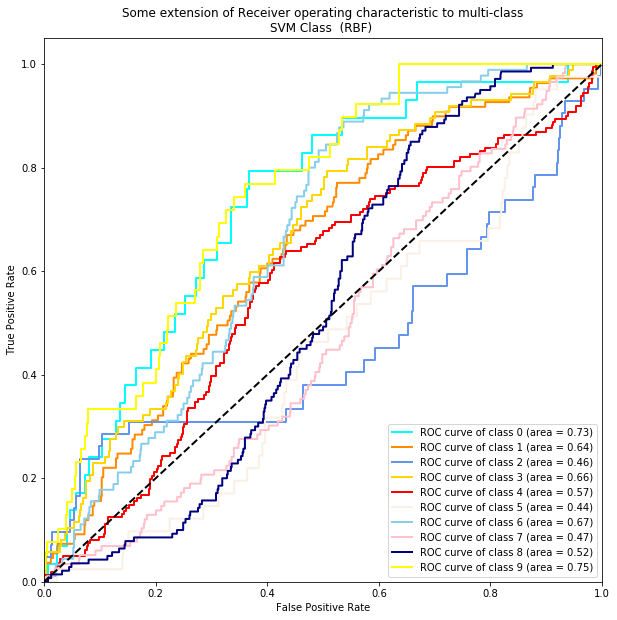

CLASSIFIER :  SVM Class  (LIN) 


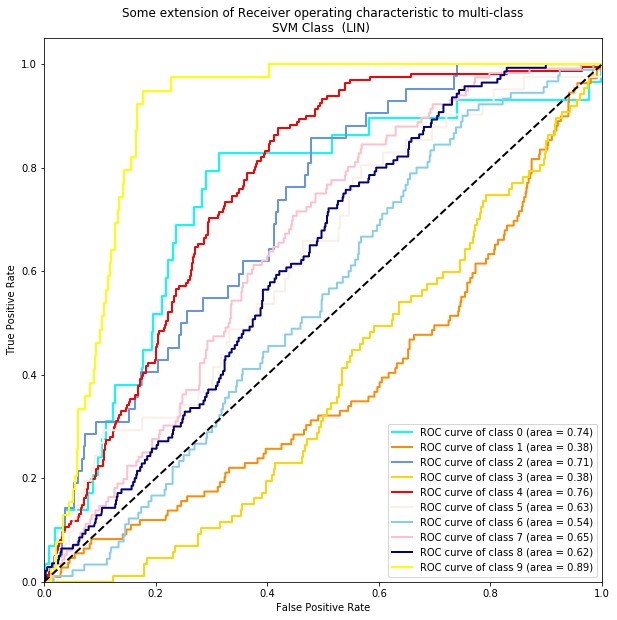

CLASSIFIER :  Arbre De décision
CLASSIFIER :  Forêt Aléatoire  
CLASSIFIER :  Adab (RF_Class)  


In [25]:
l5 = ['FI_Price', 'FI_Article_Nb', 'FI_Mean_Article_Price']
a,b,c,d = stt.lancement_comparaison_classifier_V3(
    data=clients_bis, 
    l_col=l5, 
    n_col_cible='couleur',
    knn_nb=5,
    rf_nb_estimators=20,
    rf_nb_max_features=3,
    ab_nb_estimators=1,
    ab_learning_rate=5, 
    #affiche_info_classifiers=False, 
    affiche_matrice_confusion=False
)

In [26]:
l6 = [ 'Mean_Invoice_Price', 'Nb_Article_Total', 'Mean_Article_Price',
        'FI_Price', 'FI_Article_Nb', 'FI_Mean_Article_Price']
a,b,c,d = stt.lancement_comparaison_classifier(
    data=clients, 
    l_col=l6, 
    n_col_cible='couleur',
    knn_nb=7,
    rf_nb_estimators=200,
    rf_nb_max_features=5,
    #affiche_info_classifiers=False
)

Classifier - KNN               --> Score : 0.4630
Classifier - SVM Class  (RBF)  --> Score : 0.3845
Classifier - SVM Class  (LIN)  --> Score : 0.3938
Classifier - Arbre De décision --> Score : 0.5843
Classifier - Forêt Aléatoire   --> Score : 0.6051
Classifier - Adaboost          --> Score : 0.3510


# LANCEMENT DU PROGRAMME
/!\ Il faut lancer le programme 'lancement_programme'

In [27]:
def lancement_programme():
    '''Lancement du programme general'''
    #my_data_to_classify = pd.read_csv('Data_Filtree_Etape1.csv')

    my_data_to_classify = pd.read_csv('FICHIER_TRANSACTIONS.csv')
    vector_label = stt.global_genere_prediction(my_data_to_classify)
    
    return vector_label